In [ ]:
#  Installation of the following additional packages
!pip install transformers
!pip install datasets

## Importing Data

In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

--2022-01-12 12:07:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  37.1MB/s    in 1.1s    

2022-01-12 12:07:16 (37.1 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [78]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
# \t is the tab character in Python
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

Using custom data configuration default-3761173c276c0a9a
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-3761173c276c0a9a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [74]:
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['condition', 'date', 'drugName', 'patient_id', 'rating', 'review', 'review_length', 'usefulCount'],
        num_rows: 160398
    })
    test: Dataset({
        features: ['condition', 'date', 'drugName', 'patient_id', 'rating', 'review', 'review_length', 'usefulCount'],
        num_rows: 53471
    })
})

## Preparing Data

Getting a small sample to play around

In [75]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))
# Peek at the first few examples
drug_sample[:3]

{'condition': ['birth control', 'acne', 'light sedation'],
 'date': ['August 6, 2011', 'July 7, 2016', 'March 9, 2009'],
 'drugName': ['Loestrin 24 Fe', 'Adapalene', 'Promethazine'],
 'patient_id': [220552, 47811, 177091],
 'rating': [10.0, 10.0, 1.0],
 'review': ['"I&#039;ve been on Loestrin almost 2 years now and have no real complaints! Nowhere near the weight gain I had while previously on Depo (maybe a pound or 2 on Loestrin) and my breasts have become significantly bigger (to the happiness of my boyfriend) and my skin is SO much smoother (also huge perk for him). I would really give it a 9.5 rating because those times when my period comes a day or 2 later then it should (because it only lasts 2 days at max) I start worrying if I&#039;m pregnant, but in the end, never am! My doctor said if I hated the paranoia then to use a back up birth control too."',
  '"This is so good, initially I was not keen because of most said about having a bigger breakout on top of what I was already su

Get train, test, and split dataset

In [76]:
drug_dataset_clean = drug_dataset["train"].train_test_split(train_size=0.8, seed=42)
# Rename the default "test" split to "validation"
drug_dataset_clean["validation"] = drug_dataset_clean.pop("test")
# Add the "test" set to our `DatasetDict`
drug_dataset_clean["test"] = drug_dataset["test"]
drug_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['condition', 'date', 'drugName', 'patient_id', 'rating', 'review', 'review_length', 'usefulCount'],
        num_rows: 128318
    })
    validation: Dataset({
        features: ['condition', 'date', 'drugName', 'patient_id', 'rating', 'review', 'review_length', 'usefulCount'],
        num_rows: 32080
    })
    test: Dataset({
        features: ['condition', 'date', 'drugName', 'patient_id', 'rating', 'review', 'review_length', 'usefulCount'],
        num_rows: 53471
    })
})

## Cleaning Data
(1) Renaming the first column

In [82]:
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)
drug_dataset

ValueError: ignored

(2) Lowercase all strings in the variable "condition"

In [ ]:
def lowercase_condition(example):
    return {"condition": example["condition"].lower()}

drug_dataset.map(lowercase_condition)

In [84]:
  drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-3761173c276c0a9a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-ec6c58fc0f35d2c1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-3761173c276c0a9a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-f65a761bf5c69848.arrow


In [85]:
drug_dataset = drug_dataset.map(lowercase_condition)
# Check that lowercasing worked
drug_dataset["train"]["condition"][:3]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-3761173c276c0a9a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-90329f84be2017d4.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-3761173c276c0a9a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-2c522743542cd546.arrow


['left ventricular dysfunction', 'adhd', 'birth control']

## Creating New Columns

In [86]:
def compute_review_length(example):
    return {"review_length": len(example["review"])}

drug_dataset = drug_dataset.map(compute_review_length)
# Inspect the first training example
drug_dataset["train"][0]

  0%|          | 0/160398 [00:00<?, ?ex/s]

  0%|          | 0/53471 [00:00<?, ?ex/s]

{'condition': 'left ventricular dysfunction',
 'date': 'May 20, 2012',
 'drugName': 'Valsartan',
 'patient_id': 206461,
 'rating': 9.0,
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'review_length': 79,
 'usefulCount': 27}

In [87]:
# Batch version of the function
def compute_review_length(example):
    return {"review_length": [len(e) for e in example["review"]]}

drug_dataset = drug_dataset.map(compute_review_length, batched=True)
# Inspect the first training example
drug_dataset["train"][0]

  0%|          | 0/161 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

{'condition': 'left ventricular dysfunction',
 'date': 'May 20, 2012',
 'drugName': 'Valsartan',
 'patient_id': 206461,
 'rating': 9.0,
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'review_length': 79,
 'usefulCount': 27}

Looking at extreme values

In [89]:
drug_dataset["train"].sort("review_length")[:3]

Loading cached sorted indices for dataset at /root/.cache/huggingface/datasets/csv/default-3761173c276c0a9a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-741770a15d3f8cdf.arrow


{'condition': ['testicular cance', 'testicular cance', 'min)'],
 'date': ['January 8, 2017', 'January 8, 2017', 'April 19, 2012'],
 'drugName': ['Ifosfamide', 'Ifex', 'Linagliptin / metformin'],
 'patient_id': [180087, 116477, 162018],
 'rating': [10.0, 10.0, 9.0],
 'review': ['"-"', '"-"', '"G"'],
 'review_length': [3, 3, 3],
 'usefulCount': [0, 0, 3]}

## Saving Data

In [71]:
drug_dataset.save_to_disk("drug-reviews")

Using the standard Arrows format results in a folder including a subfolder for each dataset in the dictionary, JSON files including meta data, and arrow files including the actual data.
The structure is similar to the one below.  
For CSV and JSON exports (`Dataset.to_csv()` / `Dataset.to_json()`) the datasets are saved separately.

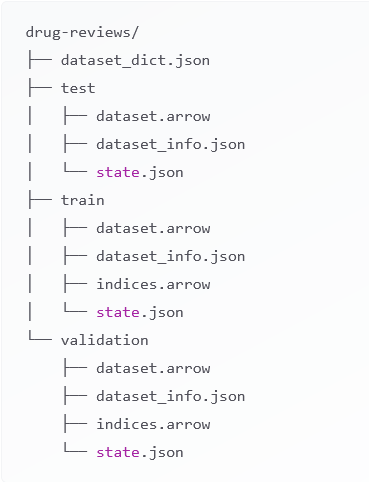

## Using a Dataset as a Pandas dataframe

In [90]:
drug_dataset.set_format("pandas")

drug_dataset["train"][:3]

,condition,date,drugName,patient_id,rating,review,review_length,usefulCount
0,left ventricular dysfunction,"May 20, 2012",Valsartan,206461,9.0,"""It has no side effect, I take it in combinati...",79,27
1,adhd,"April 27, 2010",Guanfacine,95260,8.0,"""My son is halfway through his fourth week of ...",741,192
2,birth control,"December 14, 2009",Lybrel,92703,5.0,"""I used to take another oral contraceptive, wh...",755,17


In [91]:
drug_dataset.reset_format()

drug_dataset["train"][:3]

{'condition': ['left ventricular dysfunction', 'adhd', 'birth control'],
 'date': ['May 20, 2012', 'April 27, 2010', 'December 14, 2009'],
 'drugName': ['Valsartan', 'Guanfacine', 'Lybrel'],
 'patient_id': [206461, 95260, 92703],
 'rating': [9.0, 8.0, 5.0],
 'review': ['"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
  '"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behav